# Outwasher module flow routing algorithm: changes from Barrier3d

Currently, the outwasher module has no dunes or shrubs in the system and also routes water in the opposite direction as Barrier3d. Therefore, significant changes have been made to Outwasher's flow routing algorithm (*removed all variables/segments of codes with dunes*). We still use many parameters from Barrier3D, but we start by initializing our own storm series. The first position is the year the storm occurs, second is the bayhigh level in dam, and third is the duration in hours. This differs from B3D's storm series which has a few more columns. 

```Python
        storm_series = [[1, 0.1, 40], [1, 0.2, 57], [1, 0.05, 65]]
```

Then, we initialize numstorm as the length of storm series instead of setting it to 0 and <b>REMOVE<b>: 
```Python
        start = TSloc[0, 0]
        stop = TSloc[-1, 0] + 1
        Rhigh = self._StormSeries[start:stop, 1]
        Rlow = self._StormSeries[start:stop, 2]
        dur = np.array(self._StormSeries[start:stop, 4], dtype="int")
```
from right under the `if numstorm > 0:` statement because it is mostly used for dune stuff. Rhigh is replaced with bayhigh and dur is set later.

We enter the storm loop, and set the `bayhigh` and `dur` using the current storm number (n):
```Python
        for n in range(numstorm):
            bayhigh = storm_series[n][1]
            dur = storm_series[n][2]
```

Then we alter the sediment and water routing rules to use only the inundation regime because this is when we will get outwash events: 
``` Python
            ### Determine Sediment And Water Routing Rules
            inundation = 1
            substep = b3d._OWss_i

```
And lastly in this section, we set the domain. This is very similar to B3D except we flip the interior domain so that we have bayside on top and oceanside on bottom, and we also create a beach of constant elevation and add it to the interioir domain on the oceanside. The `width` and `elevation` variables have not changed from B3D, and `Discharge, SedFluxIn, and SedFLuxOut` were also initialized the same way. We do change the way that Si is calculated from B3D which is `AvgSlope = self._BermEl / 20`
```Python
            ### Set Domain
            add = 10
            interior_domain = np.flip(b3d._InteriorDomain, 0)
            beach_domain = np.ones([add, b3d._BarrierLength]) * b3d._BermEl
            full_domain = np.append(interior_domain, beach_domain, 0)
            
            ## width is the number of rows in the full domain
            width = np.shape(full_domain)[0]
            duration = dur * substep
            Elevation = np.zeros([duration, width, b3d._BarrierLength])
            # elevation at the first time step is set to the full domain
            Elevation[0, :, :] = full_domain

            # Initialize Memory Storage Arrays
            Discharge = np.zeros([duration, width, b3d._BarrierLength])
            SedFluxIn = np.zeros([duration, width, b3d._BarrierLength])
            SedFluxOut = np.zeros([duration, width, b3d._BarrierLength])

            # get the average slope of the inerior using first and last rows of just the interior domain
            # should be negative because the first row is close to bay and last row close to "dunes"
            Si = np.mean((interior_domain[-1, :] - interior_domain[0, :]) / 20)
```
The `### Set Water at Dune Crest` has only chnaged names of variables, but will probably need to be changed because it is not an accurate representation of what occurs during outwash. 
```Python
            # ### Set Water at Dune Crest
            # these equations will probably need to be changed
            Rexcess = bayhigh
            overtop_vel = np.sqrt(2 * 9.8 * (Rexcess * 10)) / 10  # (dam/s)
            overtop_flow = overtop_vel * Rexcess * 3600  # (dam^3/hr)
            # our initial discharge amount starts at the first row and is later distributed down the rows/cols
            Discharge[:, 0, :] = overtop_flow
            C = b3d._Cx * Si  # 10 x the avg slope (from Murray)

```


We have removed the `### Dune Erosion` and `### Overwash` sections because they are for dunes. 

The `### Run Flow Routing Algorithm` has not changed much aside from removing all dune and shrub segments. The outer most loop is for each time step (TS), then for each row (d), and lastly for each column (i). The `fluxLimit` has been changed to an arbitrary value for now. The next area that has changes to it is the `### Calculate Net Erosion/Accretion` because the current algorithm does not make sense for our flow. In B3D, the algorithm looks at 10 rows at a time and determines if any are under water (at or under bay elevation) because it is routing water toward the bay. If there are no cells under water, the elevation change at the particular row and column is determined by the sediment flux in versus sediment flux out. If any of the 10 rows are under water, the sediment is distributed exponentially across the bay. 
```Python 
            if Elevation[TS, d, i] > self._SL or any(
                z > self._SL
                for z in Elevation[TS, d + 1 : d + 10, i]
            ):  # If cell is subaerial, elevation change is determined by difference between
                # flux in vs. flux out
                if i > 0:
                    SedFluxIn[TS, d + 1, i - 1] += Qs1

                SedFluxIn[TS, d + 1, i] += Qs2

                if i < (self._BarrierLength - 1):
                    SedFluxIn[TS, d + 1, i + 1] += Qs3

                Qs_out = Qs1 + Qs2 + Qs3
                SedFluxOut[TS, d, i] = Qs_out

            else:  # If cell is subaqeous, exponentially decay dep. of remaining sed across bay

                if inundation == 0:
                    Cbb = self._Cbb_r
                else:
                    Cbb = self._Cbb_i

                Qs0 = SedFluxIn[TS, d, i] * Cbb

                Qs1 = Qs0 * Q1 / (Q1 + Q2 + Q3)
                Qs2 = Qs0 * Q2 / (Q1 + Q2 + Q3)
                Qs3 = Qs0 * Q3 / (Q1 + Q2 + Q3)

                Qs1 = np.nan_to_num(Qs1)
                Qs2 = np.nan_to_num(Qs2)
                Qs3 = np.nan_to_num(Qs3)

                if Qs1 < self._Qs_bb_min:
                    Qs1 = 0
                elif Qs1 > fluxLimit:
                    Qs1 = fluxLimit
                if Qs2 < self._Qs_bb_min:
                    Qs2 = 0
                elif Qs2 > fluxLimit:
                    Qs2 = fluxLimit
                if Qs3 < self._Qs_bb_min:
                    Qs3 = 0
                elif Qs3 > fluxLimit:
                    Qs3 = fluxLimit

                if i > 0:
                    SedFluxIn[TS, d + 1, i - 1] += Qs1

                SedFluxIn[TS, d + 1, i] += Qs2

                if i < (self._BarrierLength - 1):
                    SedFluxIn[TS, d + 1, i + 1] += Qs3

                Qs_out = Qs1 + Qs2 + Qs3
                SedFluxOut[TS, d, i] = Qs_out
```
This obviously does not make sense when we are routing water in the opposite direction. Therefore, we look for the beach elevation instead of the bay elevation, and if there is a beach elevation, we exponentially decay the sediment across the beach. STILL NEEDS TO BE WRITTEN BY ME

The `### Update Elevation After Every Storm Hour` and the `### Update Interior Domain After Every Storm` have not changed aside from removing dunes and shrubs.

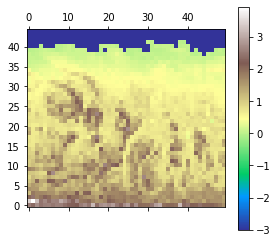

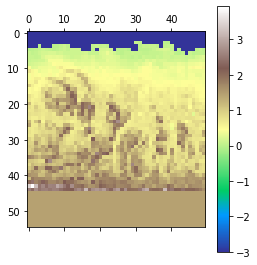

In [1]:
from cascade import outwasher